In [1]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import *
from tensorflow.keras.backend import clear_session

import numpy as np
import matplotlib.pyplot as plt
from random import randint
from transformer import TransformerBlock, TokenAndPositionEmbedding

In [2]:
!if ! ls /tmp/FOX_train.h5; \
    wget https://repo.gorchilov.net/datasets/fox-multi-factor.tar.gz -O /tmp/fox.tar.gz; \
    tar -xf /tmp/fox.tar.gz -C /tmp; \
    end

import h5py

train = h5py.File('/tmp/FOX_train.h5', mode='r')
test = h5py.File('/tmp/FOX_test.h5', mode='r')

/tmp/FOX_train.h5


In [3]:
X_train = train['data'][:]
y_train = train['labels'][:]

X_test = test['data'][:]
y_test = test['labels'][:]

In [4]:
transposed = np.array([x.T for x in X_train])

In [5]:
sample_size = 10000

embed_dim = 4
num_heads = 2 # Number of attention heads
ff_dim = 64 # Hidden layer size in feed forward network inside transformer

clear_session()

inputs = Input(shape=(1000, 4))
# inputs = Input(shape=(1000,))

# embedding_layer = TokenAndPositionEmbedding(1000, sample_size, 4)
# x = embedding_layer(inputs)
x = inputs

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.1)(x)
outputs = Dense(31, activation='relu')(x)

model = Model(inputs, outputs)

# model.summary()

In [6]:
model.compile(optimizer=Adam(), loss='mae')
history = model.fit(
    transposed[:10000], y_train[:10000], epochs=10
)

Epoch 1/10
313/313 [==============================] - 12s 37ms/step - loss: 158.0005
Epoch 2/10
313/313 [==============================] - 12s 37ms/step - loss: 158.0002
Epoch 3/10
313/313 [==============================] - 12s 37ms/step - loss: 158.0002
Epoch 4/10
313/313 [==============================] - 12s 37ms/step - loss: 158.0001
Epoch 5/10
313/313 [==============================] - 12s 37ms/step - loss: 158.0002
Epoch 6/10
313/313 [==============================] - 12s 37ms/step - loss: 158.0001
Epoch 7/10
313/313 [==============================] - 12s 37ms/step - loss: 158.0002
Epoch 8/10
313/313 [==============================] - 12s 37ms/step - loss: 158.0000
Epoch 9/10
313/313 [==============================] - 12s 37ms/step - loss: 158.0002
Epoch 10/10
313/313 [==============================] - 12s 37ms/step - loss: 158.0001


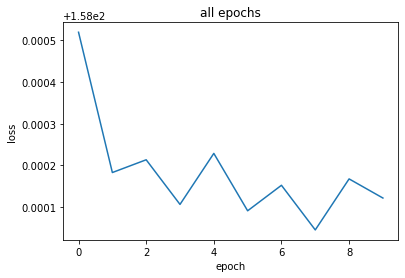

In [7]:
start = 0
end = 10

plt.title('all epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(start, end), history.history['loss'][start:end])
plt.show()

In [8]:
model.evaluate(np.array([x.T for x in X_test]), y_test)

313/313 [==============================] - 5s 15ms/step - loss: 173.6339


173.63389587402344

In [13]:
model.predict(X_train[10], 0)

ValueError: in user code:

    /home/victorgorchilov/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /home/victorgorchilov/Documents/GitHub/MachineLearning/Genetics-ML/transformer/TransformerBlock.py:20 call  *
        attn_output = self.att(inputs)
    /home/victorgorchilov/Documents/GitHub/MachineLearning/Genetics-ML/transformer/MultiHeadSelfAttention.py:36 call  *
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
    /home/victorgorchilov/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/victorgorchilov/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 4 but received input with shape [None, 1000]


In [10]:
import numpy as np
from tensorflow.keras import Model
from math import isclose

def eval_AUC(model, X: np.ndarray, y: np.ndarray, tolerance=5):
    positive_negative = []
    for i in range(len(X)): # if close to 5 -> no transcription
        pred = model.predict(np.expand_dims(X[i], 0))
        positive_negative.append(not isclose(np.sum(pred), 0, rel_tol=tolerance))

    return postive_negative

In [11]:
eval_AUC(model, X_train[:10], y_train[:10])

ValueError: in user code:

    /home/victorgorchilov/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /home/victorgorchilov/Documents/GitHub/MachineLearning/Genetics-ML/transformer/TransformerBlock.py:20 call  *
        attn_output = self.att(inputs)
    /home/victorgorchilov/Documents/GitHub/MachineLearning/Genetics-ML/transformer/MultiHeadSelfAttention.py:36 call  *
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
    /home/victorgorchilov/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/victorgorchilov/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 4 but received input with shape [None, 4, 1000]


In [ ]:
n = randint(0, len(y_test))

pred = model.predict(np.expand_dims(X_test[n].T, 0))

print(n, '\n', pred, '\n', y_test[n])

model.save('model_saves/transformer-model')